# Facebook Prophet

-The goal of this notebook is to see how effectively Facebook Prophet can forecast gun violence trends one year into the future.

In [8]:
import pandas as pd
import numpy as np
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import plot_cross_validation_metric
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

I'll first read in my main dataset and make sure (as always) that it's formatted correctly:

In [3]:
guns = pd.read_csv('../data/guns2.csv', index_col=0)
guns.head(1)

,state,city_or_county,address,n_killed,n_injured,incident_url,source_url,incident_url_fields_missing,congressional_district,gun_stolen,...,participant_age,participant_age_group,participant_gender,participant_name,participant_relationship,participant_status,participant_type,sources,state_house_district,state_senate_district
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,Pennsylvania,Mckeesport,1506 Versailles Avenue and Coursin Street,0,4,http://www.gunviolencearchive.org/incident/461105,http://www.post-gazette.com/local/south/2013/0...,0.0,14.0,NaN,...,0::20,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male||1::Male||3::Male||4::Female,0::Julian Sims,NaN,0::Arrested||1::Injured||2::Injured||3::Injure...,0::Victim||1::Victim||2::Victim||3::Victim||4:...,http://pittsburgh.cbslocal.com/2013/01/01/4-pe...,NaN,NaN


I'll make a dataframe only of n_killed from the year 2014 on. Again, I'm not going to include data from 2013 because it's incomplete:

In [4]:
df = guns[['n_killed']]
df = df.loc['2014-01-01':'2018-03-31']
df.reset_index(inplace=True)

I need to format my data into a dataframe that FB Prophet can understand. This means having two columns: a datetime series and my 'y' column, which is what I'm predicting on (number of gun deaths per day):

In [5]:
df = pd.DataFrame(df.groupby("date").n_killed.sum())
df.reset_index(inplace=True)
df.rename(columns={"date": "ds", "n_killed": 'y'}, inplace=True)
df['ds'] = pd.to_datetime(df['ds'])
df.head()

,ds,y
0,2014-01-01,50
1,2014-01-02,29
2,2014-01-03,37
3,2014-01-04,37
4,2014-01-05,31


In [6]:
np.mean(df.y)

38.895348837209305

Sidenote: I see that, on average, there are about 39 gun murders on any given day in America.

Now I'm ready to instantiate and fit my FB Prophet model:

In [10]:
m = Prophet()
m.fit(df);

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


With the model fit, I can make a dataframe of future predictions. I'm going to (try) to make predictions for a year past the date on which my data ends:

In [13]:
future = m.make_future_dataframe(periods=365, freq='D')
future.tail()

,ds
1908,2019-03-27
1909,2019-03-28
1910,2019-03-29
1911,2019-03-30
1912,2019-03-31


Now I can actually forecast using these future dates:

In [14]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1908,2019-03-27,35.220198,25.273549,44.478153
1909,2019-03-28,33.600540,23.804368,43.896435
1910,2019-03-29,36.440947,26.325337,46.323778
1911,2019-03-30,42.639294,32.742966,53.591642
1912,2019-03-31,44.655033,34.162214,54.914364


Prophet also has a built-in plotting function, which I'll check out:

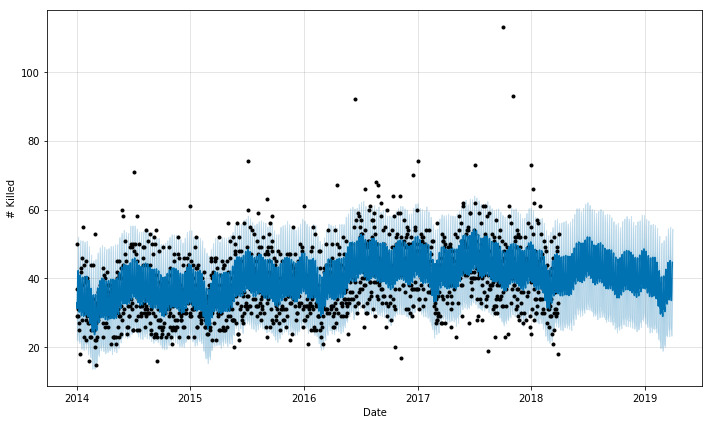

In [18]:
fig1 = m.plot(forecast, xlabel='Date', ylabel='# Killed')
plt.savefig('../images/gun_violence_forecast.png')

I can see that Prophet captures the monthly seasonality really well, but, since murders are in decline in March (the month in which my data ends), it seems to be interpreting this as an overall decline. The monthly seasonality is really good, but it's predicting an overall decline in gun deaths for 2018-2019, which, given the data from 2014-2017, I don't think will happen.

Prophet also has the built-in ability to plot components. Let's check this out, as it might be helpful:

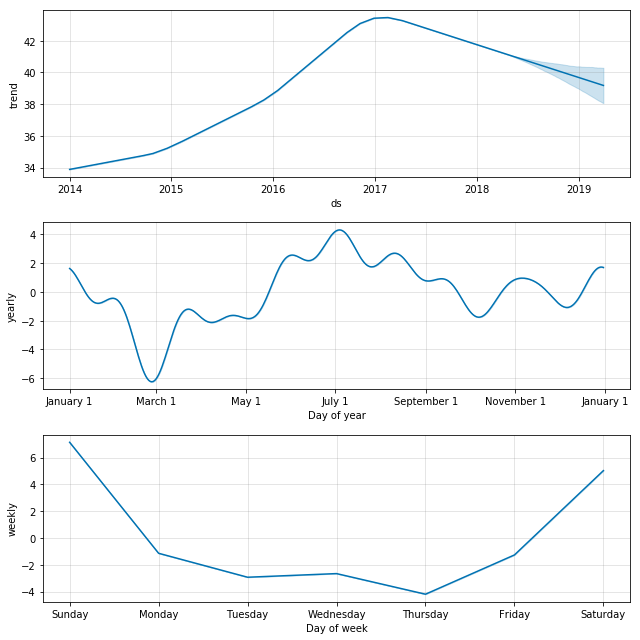

In [19]:
fig2 = m.plot_components(forecast)
plt.savefig('../images/forecast_components.png')

Again, Prophet is predicting an overall downward trend after 2017. This could very well be wrong–I'd have to scrape gunviolence.org for more recent data to confirm this. The monthly and day of the week trends are very helpful, though: murders peak in July and decline January through March.

I'll run Prophet's built-in diagnostics to see how it performs on historical data:

In [15]:
df_cv = cross_validation(m, horizon='365 days')
df_cv.tail()

INFO:fbprophet.diagnostics:Making 1 forecasts with cutoffs between 2017-03-31 00:00:00 and 2017-03-31 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
360,2018-03-27,46.710753,37.698847,55.872365,18,2017-03-31
361,2018-03-28,47.155254,37.574687,56.110464,42,2017-03-31
362,2018-03-29,44.903712,35.905365,53.884260,33,2017-03-31
363,2018-03-30,47.984975,39.185944,57.338443,41,2017-03-31
364,2018-03-31,54.154107,44.775155,63.446882,53,2017-03-31


In [14]:
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,coverage
35,36 days,40.738118,6.382642,4.807525,0.137632,0.833333
36,37 days,40.813691,6.388559,4.827064,0.138020,0.833333
37,38 days,39.910732,6.317494,4.713649,0.135442,0.833333
38,39 days,39.509523,6.285660,4.649735,0.134137,0.833333
39,40 days,41.408894,6.434974,4.818934,0.139548,0.833333


In [15]:
df_p.tail()

,horizon,mse,rmse,mae,mape,coverage
360,361 days,201.822531,14.206426,12.439157,0.418465,0.388889
361,362 days,202.349477,14.224960,12.505748,0.420134,0.388889
362,363 days,200.383277,14.155680,12.431497,0.415157,0.388889
363,364 days,200.968689,14.176343,12.479287,0.415588,0.388889
364,365 days,200.215646,14.149758,12.363206,0.412189,0.388889


It's clear that the predictions get less and less accurate the further into the future you're forecasting. RMSE begins at about 6, but deteriorates to around 14 at the end of the forecast period (in this case, one year). That might not seem like a lot, but remember that gun murders are about 39 per day. In light of this, a prediction that is 14 deaths off is not very accurate. That being said, in terms of making shorter-term predictions, Prophet could prove to be a very valuable tool.

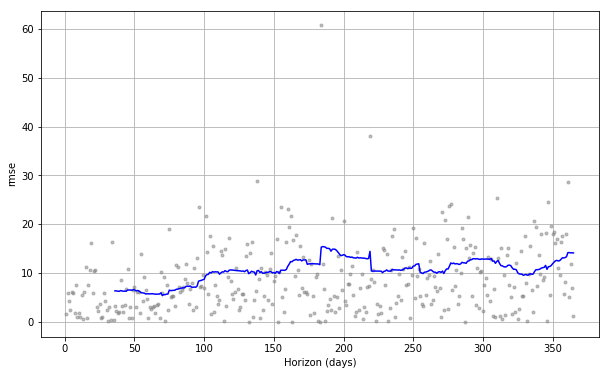

In [16]:
fig = plot_cross_validation_metric(df_cv, metric = 'rmse')